In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2


# Prepare data

**Load data** do it only once

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/lyme_dataset/ver_3/data/'
dir_augmented = '/content/drive/MyDrive/lyme_dataset/ver_3/augmented_dataset/'
test_df = pd.read_csv('/content/drive/MyDrive/lyme_dataset/ver_3/test_data.csv')
train_df = pd.read_csv('/content/drive/MyDrive/lyme_dataset/ver_3/training_data.csv')
augmented_df = pd.read_csv('/content/drive/MyDrive/lyme_dataset/ver_3/data_augmented.csv')

data = {}

target_size = (224, 224)


for i in range(len(test_df['image'])):
    image_name = dir + test_df['image'][i]
    image=tf.keras.preprocessing.image.load_img(image_name, color_mode='rgb', target_size = target_size)
    image=np.array(image)
    data.update({test_df['image'][i]: image})
    

for i in range(len(train_df['image'])):
    image_name = dir + train_df['image'][i]
    image=tf.keras.preprocessing.image.load_img(image_name, color_mode='rgb', target_size = target_size)
    image=np.array(image)
    data.update({train_df['image'][i]: image})


for i in range(len(augmented_df['image'])):
    image_name = dir_augmented + augmented_df['image'][i]
    image=tf.keras.preprocessing.image.load_img(image_name, color_mode='rgb', target_size = target_size)
    image=np.array(image)
    data.update({augmented_df['image'][i]: image})




/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
data_df = pd.concat([test_df, train_df])
data_df.reset_index(drop=True, inplace=True)
data_df = pd.concat([data_df, augmented_df])
data_df = data_df.sample(frac=1, random_state=123)
data_df.reset_index(drop=True, inplace=True)

clean_lyme_count = data_df[(data_df['lyme_positive'] == 1) & (data_df['clean'] == 1)].count()['clean']

prepare data func

In [ ]:
def prepare_data(noisy_part):


  result_label = []
  result_data = []


  clean_no_lyme_count = 0
  noisy_lyme_count = 0
  noisy_no_lyme_count = 0

  noise_threshold = clean_lyme_count / (1 - noisy_part) * noisy_part



  for i in range(len(data_df['image'])):

      if (data_df['clean'][i] == 1) and (data_df['lyme_positive'][i] == 1):
          result_label.append(data_df['lyme_positive'][i])
          result_data.append(data[data_df['image'][i]])
      
      if (data_df['clean'][i] == 1) and (data_df['lyme_positive'][i] == 0) and (clean_no_lyme_count < clean_lyme_count):
          result_label.append(data_df['lyme_positive'][i])
          result_data.append(data[data_df['image'][i]])
          clean_no_lyme_count += 1

      if noisy_part > 0:

          if (data_df['clean'][i] == 0) and (data_df['lyme_positive'][i] == 1) and (noisy_no_lyme_count < noise_threshold):
              result_label.append(data_df['lyme_positive'][i])
              result_data.append(data[data_df['image'][i]])
              noisy_no_lyme_count += 1

          if (data_df['clean'][i] == 0) and (data_df['lyme_positive'][i] == 0) and (noisy_lyme_count < noise_threshold):
              result_label.append(data_df['lyme_positive'][i])
              result_data.append(data[data_df['image'][i]])
              noisy_lyme_count += 1

  
  result_data = np.asarray(result_data).astype(np.float32)
  result_label = np.asarray(result_label).astype(np.float32)

  print('dataset size: ',len(result_data))

  return result_data, result_label



# Plot functions

In [ ]:
def show_model_results(acc_per_fold, loss_per_fold, auc_per_fold):
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]} - AUC: {auc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> AUC: {np.mean(auc_per_fold)} (+- {np.std(auc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')

In [ ]:
def plot_mean_std(label, line_color, fill_color, epoch_list, mean_list, std_list, ax):
  
  ax.plot(
    epoch_list,
    mean_list,
    color=line_color,
    label=label, 
    lw=2,
    alpha=0.8,
  )

  upper = (mean_list + std_list)
  lower = (mean_list - std_list)

  ax.fill_between(
    epoch_list,
    lower,
    upper,
    color=fill_color,
    alpha=0.5,
    label=r"$\pm$ 1 std. dev.",
  )


def plot_train_val_mean_std(metric_label, legend_location, metric_ylim, history_train_list_means, history_train_list_stds, history_val_list_means, history_val_list_stds, ax):


  epochs_list = range(EPOCHS)

  plot_mean_std('train', 'r', "lightcoral", epochs_list, history_train_list_means, history_train_list_stds, ax)
  plot_mean_std('val', 'b', "lightsteelblue", epochs_list, history_val_list_means, history_val_list_stds, ax)

  ax.set(
    xlim = [0, EPOCHS-1],
    ylim = metric_ylim,
    title = metric_label + " - History",
  )

  ax.legend(loc=legend_location, ncol=2)
  plt.show()  


# Model_class

In [ ]:
class Base_Model(tf.keras.Model):

  def __init__(self, target_size):
    super().__init__()
    self.target_size = target_size
    self.base_model = MobileNetV2(
    include_top=False,
    pooling='max', weights='imagenet', input_shape = self.target_size)
    print(target_size)

    self.flat_layer = tf.keras.layers.Flatten()
    self.dense1_layer = tf.keras.layers.Dense(512, activation='relu')
    self.dense2_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs, training=False):
    x = self.base_model(inputs)
    x = self.flat_layer(x)
    x = self.dense1_layer(x)


    return self.dense2_layer(x)
    

In [ ]:
class Complex_Model():

  def __init__(self, result_data, result_label, save_dir, epoch_num, 
               target_size = (224, 224, 3), num_folds = 5):
    
    self.X = result_data
    self.Y = result_label
    self.target_size = target_size
    self.save_dir = save_dir
    self.epoch_num = epoch_num
    self.num_folds = num_folds

    self.acc_per_fold = []
    self.loss_per_fold = []
    self.auc_per_fold = []

    self.history_acc_list = []
    self.history_loss_list = []
    self.history_auc_list = []
    self.history_val_acc_list = []
    self.history_val_loss_list = []
    self.history_val_auc_list = []



  def run(self):

    kfold = StratifiedKFold(n_splits = self.num_folds)
  

    for train, test in kfold.split(self.X, self.Y):

      model = Base_Model(self.target_size)

      model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                  loss = 'binary_crossentropy', 
                  metrics = [tf.keras.metrics.AUC(name='auc'),'acc'])


      train_data_aug = ImageDataGenerator(rescale=1./255).flow(self.X[train], self.Y[train])
      test_data_aug = ImageDataGenerator(rescale=1./255).flow(self.X[test], self.Y[test])

      checkpoint_AUC = ModelCheckpoint(save_dir, monitor='val_auc', verbose=2, save_best_only=True, 
                                      mode='max', save_weights_only=True)

      history = model.fit(
        train_data_aug,               
        epochs=self.epoch_num,
        verbose=2,
        callbacks = [checkpoint_AUC],
        validation_data=test_data_aug)
      
      model.load_weights(save_dir)
      
      scores = model.evaluate(test_data_aug, verbose=0)

      self.loss_per_fold.append(scores[0])
      self.auc_per_fold.append(scores[1])
      self.acc_per_fold.append(scores[2])

      
      self.history_acc_list.append(history.history['acc'])
      self.history_loss_list.append(history.history['loss'])
      self.history_auc_list.append(history.history['auc'])
      self.history_val_acc_list.append(history.history['val_acc'])
      self.history_val_loss_list.append(history.history['val_loss'])
      self.history_val_auc_list.append(history.history['val_auc'])


  def show_results(self):
    show_model_results(self.acc_per_fold, self.loss_per_fold, self.auc_per_fold)


  def history_stat_metrics(self, history_list):
    history_list_means = np.mean(np.asarray(history_list),axis=0)
    history_list_stds = np.std(np.asarray(history_list),axis=0)
    return(history_list_means, history_list_stds)


  def plot_accuracy(self):

    train_acc_list_means, train_acc_list_stds = self.history_stat_metrics(self.history_acc_list)
    val_acc_list_means, val_acc_list_stds = self.history_stat_metrics(self.history_val_acc_list)

    fig, ax = plt.subplots()

    plot_train_val_mean_std('Accuracy', "lower center", [0.01, 1.05], train_acc_list_means, 
                        train_acc_list_stds, val_acc_list_means, val_acc_list_stds, ax)
    
   
  def plot_loss(self):

    train_auc_list_means, train_auc_list_stds = self.history_stat_metrics(self.history_auc_list)
    val_auc_list_means, val_auc_list_stds = self.history_stat_metrics(self.history_val_auc_list)

    fig, ax = plt.subplots()

    plot_train_val_mean_std('AUC', "lower center", [0.01, 1.05], train_auc_list_means, train_auc_list_stds, 
                        val_auc_list_means, val_auc_list_stds, ax)



  def plot_auc(self):

    train_loss_list_means, train_loss_list_stds = self.history_stat_metrics(self.history_loss_list)
    val_loss_list_means, val_loss_list_stds = self.history_stat_metrics(self.history_val_loss_list)

    fig, ax = plt.subplots()

    plot_train_val_mean_std('Loss', "upper center", [0.01, 6], train_loss_list_means, train_loss_list_stds, 
                        val_loss_list_means, val_loss_list_stds, ax) 


  def folds_mean_max_auc(self):
    return np.mean(self.acc_per_fold), np.std(self.acc_per_fold), np.mean(self.auc_per_fold), np.std(self.auc_per_fold) 

    

  

    





# Zero noise


In [ ]:
EPOCHS = 30
result_data, result_label = prepare_data(noisy_part = 0)

save_dir = '/content/drive/MyDrive/lyme_dataset/weights/ver_2/model_1/'

model_noise_0 = Complex_Model(result_data=result_data, result_label=result_label, save_dir=save_dir, epoch_num = EPOCHS)

dataset size:  130


In [ ]:
model_noise_0.run()

9420800/9406464 [==============================] - 0s 0us/step
(224, 224, 3)
Epoch 1/30

Epoch 00001: val_auc improved from -inf to 0.78402, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_1/
4/4 - 19s - loss: 2.7557 - auc: 0.6172 - acc: 0.5577 - val_loss: 1.3565 - val_auc: 0.7840 - val_acc: 0.5769 - 19s/epoch - 5s/step
Epoch 2/30

Epoch 00002: val_auc improved from 0.78402 to 0.79290, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_1/
4/4 - 2s - loss: 0.6319 - auc: 0.8968 - acc: 0.7981 - val_loss: 0.6035 - val_auc: 0.7929 - val_acc: 0.6923 - 2s/epoch - 459ms/step
Epoch 3/30

Epoch 00003: val_auc improved from 0.79290 to 0.79882, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_1/
4/4 - 2s - loss: 0.0631 - auc: 0.9978 - acc: 0.9615 - val_loss: 0.5517 - val_auc: 0.7988 - val_acc: 0.8462 - 2s/epoch - 457ms/step
Epoch 4/30

Epoch 00004: val_auc improved from 0.79882 to 0.81953, saving model to /content/drive/MyDrive/ly

In [ ]:
model_noise_0.show_results()

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5377193093299866 - Accuracy: 0.807692289352417 - AUC: 0.884615421295166%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8012552857398987 - Accuracy: 0.6538461446762085 - AUC: 0.8550295233726501%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.9666821956634521 - Accuracy: 0.5384615659713745 - AUC: 0.7278106212615967%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4677870571613312 - Accuracy: 0.807692289352417 - AUC: 0.8905325531959534%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9786700010299683 - Accuracy: 0.6538461446762085 - AUC: 0.769230842590332%
------------------------------------------------------------------------
Average 

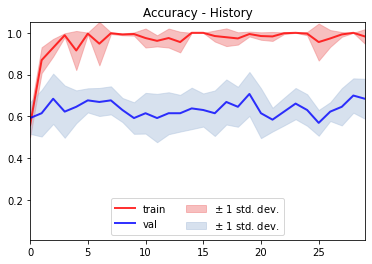

In [ ]:
model_noise_0.plot_accuracy()

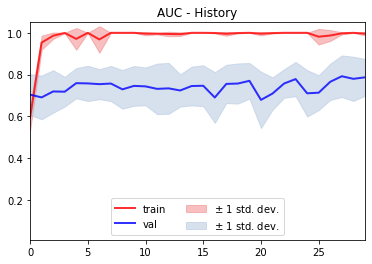

In [ ]:
model_noise_0.plot_loss()

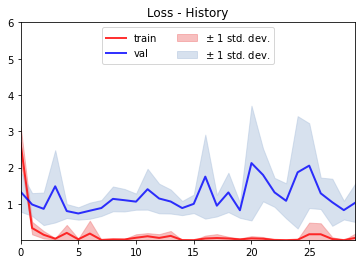

In [ ]:
model_noise_0.plot_auc()

# noise 0.1

In [ ]:
result_data, result_label = prepare_data(noisy_part = 0.1)

save_dir = '/content/drive/MyDrive/lyme_dataset/weights/ver_2/model_2/'

model_noise_10 = Complex_Model(result_data=result_data, result_label=result_label, save_dir=save_dir, epoch_num = EPOCHS)

dataset size:  146


In [ ]:
model_noise_10.run()

(224, 224, 3)
Epoch 1/30

Epoch 00001: val_auc improved from -inf to 0.56444, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_2/
4/4 - 17s - loss: 2.0134 - auc: 0.6243 - acc: 0.5776 - val_loss: 2.7545 - val_auc: 0.5644 - val_acc: 0.5667 - 17s/epoch - 4s/step
Epoch 2/30

Epoch 00002: val_auc improved from 0.56444 to 0.72000, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_2/
4/4 - 2s - loss: 0.2390 - auc: 0.9784 - acc: 0.9224 - val_loss: 1.3137 - val_auc: 0.7200 - val_acc: 0.6000 - 2s/epoch - 494ms/step
Epoch 3/30

Epoch 00003: val_auc did not improve from 0.72000
4/4 - 2s - loss: 0.0284 - auc: 0.9997 - acc: 0.9914 - val_loss: 1.2817 - val_auc: 0.7000 - val_acc: 0.6000 - 2s/epoch - 376ms/step
Epoch 4/30

Epoch 00004: val_auc did not improve from 0.72000
4/4 - 2s - loss: 0.0027 - auc: 1.0000 - acc: 1.0000 - val_loss: 1.3335 - val_auc: 0.7044 - val_acc: 0.6000 - 2s/epoch - 375ms/step
Epoch 5/30

Epoch 00005: val_auc did not improve from 0.72

In [ ]:
model_noise_10.show_results()

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.313699722290039 - Accuracy: 0.6000000238418579 - AUC: 0.7199999690055847%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0578758716583252 - Accuracy: 0.7241379022598267 - AUC: 0.7809523940086365%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6907147765159607 - Accuracy: 0.6896551847457886 - AUC: 0.8404762148857117%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6012740135192871 - Accuracy: 0.7931034564971924 - AUC: 0.8619047403335571%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8842748403549194 - Accuracy: 0.5862069129943848 - AUC: 0.7071428298950195%
------------------------------------------------------------------------
Avera

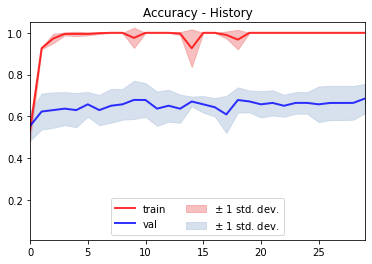

In [ ]:
model_noise_10.plot_accuracy()

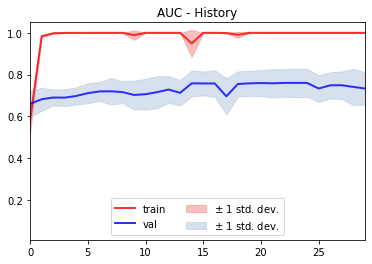

In [ ]:
model_noise_10.plot_loss()

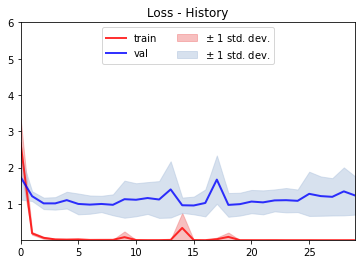

In [ ]:
model_noise_10.plot_auc()

# noise 0.3

In [ ]:
result_data, result_label = prepare_data(noisy_part = 0.3)

save_dir = '/content/drive/MyDrive/lyme_dataset/weights/ver_2/model_3/'

model_noise_30 = Complex_Model(result_data=result_data, result_label=result_label, save_dir=save_dir, epoch_num = EPOCHS)

dataset size:  186


In [ ]:
model_noise_30.run()

(224, 224, 3)
Epoch 1/30

Epoch 00001: val_auc improved from -inf to 0.60665, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_3/
5/5 - 17s - loss: 1.8132 - auc: 0.6715 - acc: 0.5608 - val_loss: 1.2549 - val_auc: 0.6066 - val_acc: 0.5263 - 17s/epoch - 3s/step
Epoch 2/30

Epoch 00002: val_auc improved from 0.60665 to 0.64543, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_3/
5/5 - 2s - loss: 0.2136 - auc: 0.9743 - acc: 0.9054 - val_loss: 1.1078 - val_auc: 0.6454 - val_acc: 0.5789 - 2s/epoch - 478ms/step
Epoch 3/30

Epoch 00003: val_auc did not improve from 0.64543
5/5 - 2s - loss: 0.0688 - auc: 0.9984 - acc: 0.9662 - val_loss: 1.1900 - val_auc: 0.6399 - val_acc: 0.5000 - 2s/epoch - 385ms/step
Epoch 4/30

Epoch 00004: val_auc did not improve from 0.64543
5/5 - 2s - loss: 0.0105 - auc: 1.0000 - acc: 1.0000 - val_loss: 1.3595 - val_auc: 0.6440 - val_acc: 0.5000 - 2s/epoch - 378ms/step
Epoch 5/30

Epoch 00005: val_auc did not improve from 0.64

In [ ]:
model_noise_30.show_results()

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.117620587348938 - Accuracy: 0.6842105388641357 - AUC: 0.7160664796829224%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.7138214111328125 - Accuracy: 0.5405405163764954 - AUC: 0.6505848169326782%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7162829041481018 - Accuracy: 0.7837837934494019 - AUC: 0.8011695742607117%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.5907161235809326 - Accuracy: 0.5945945978164673 - AUC: 0.8874269127845764%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.7233039736747742 - Accuracy: 0.6756756901741028 - AUC: 0.878654956817627%
------------------------------------------------------------------------
Averag

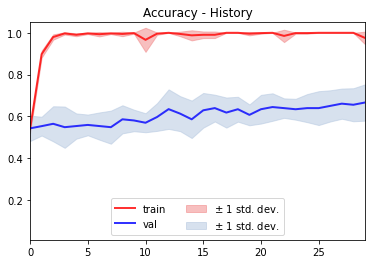

In [ ]:
model_noise_30.plot_accuracy()

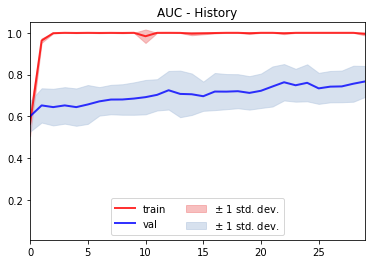

In [ ]:
model_noise_30.plot_loss()

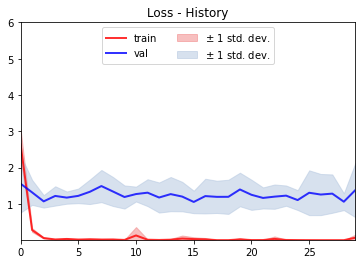

In [ ]:
model_noise_30.plot_auc()

# noise 0.5

In [ ]:
result_data, result_label = prepare_data(noisy_part = 0.5)

save_dir = '/content/drive/MyDrive/lyme_dataset/weights/ver_2/model_4/'

model_noise_50 = Complex_Model(result_data=result_data, result_label=result_label, save_dir=save_dir, epoch_num = EPOCHS)

dataset size:  260


In [ ]:
model_noise_50.run()

(224, 224, 3)
Epoch 1/30

Epoch 00001: val_auc improved from -inf to 0.53033, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_4/
7/7 - 17s - loss: 2.3233 - auc: 0.5312 - acc: 0.5144 - val_loss: 2.2485 - val_auc: 0.5303 - val_acc: 0.5192 - 17s/epoch - 2s/step
Epoch 2/30

Epoch 00002: val_auc improved from 0.53033 to 0.53402, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_4/
7/7 - 3s - loss: 0.2795 - auc: 0.9579 - acc: 0.8846 - val_loss: 1.0258 - val_auc: 0.5340 - val_acc: 0.4808 - 3s/epoch - 441ms/step
Epoch 3/30

Epoch 00003: val_auc did not improve from 0.53402
7/7 - 3s - loss: 0.0677 - auc: 0.9984 - acc: 0.9712 - val_loss: 1.4632 - val_auc: 0.5318 - val_acc: 0.5192 - 3s/epoch - 387ms/step
Epoch 4/30

Epoch 00004: val_auc did not improve from 0.53402
7/7 - 3s - loss: 0.0277 - auc: 1.0000 - acc: 0.9904 - val_loss: 1.1891 - val_auc: 0.5340 - val_acc: 0.5769 - 3s/epoch - 379ms/step
Epoch 5/30

Epoch 00005: val_auc improved from 0.53402 to 

In [ ]:
model_noise_50.show_results()

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.6846801042556763 - Accuracy: 0.5961538553237915 - AUC: 0.7951183319091797%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0529839992523193 - Accuracy: 0.7307692170143127 - AUC: 0.7581360936164856%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2385993003845215 - Accuracy: 0.6538461446762085 - AUC: 0.7300295233726501%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8018426299095154 - Accuracy: 0.7115384340286255 - AUC: 0.7943787574768066%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6493361592292786 - Accuracy: 0.807692289352417 - AUC: 0.9068046808242798%
------------------------------------------------------------------------
Avera

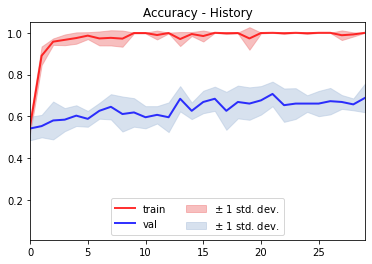

In [ ]:
model_noise_50.plot_accuracy()

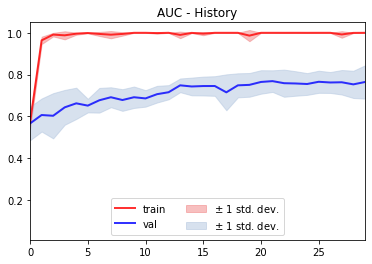

In [ ]:
model_noise_50.plot_loss()

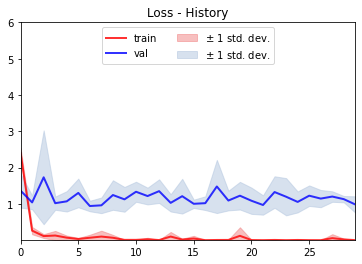

In [ ]:
model_noise_50.plot_auc()

# noise 0.7

In [ ]:
result_data, result_label = prepare_data(noisy_part = 0.7)

save_dir = '/content/drive/MyDrive/lyme_dataset/weights/ver_2/model_5/'

model_noise_70 = Complex_Model(result_data=result_data, result_label=result_label, save_dir=save_dir, epoch_num = EPOCHS)

dataset size:  434


In [ ]:
model_noise_70.run()

(224, 224, 3)
Epoch 1/30

Epoch 00001: val_auc improved from -inf to 0.66173, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_5/
11/11 - 20s - loss: 1.9984 - auc: 0.6352 - acc: 0.5821 - val_loss: 1.2475 - val_auc: 0.6617 - val_acc: 0.5862 - 20s/epoch - 2s/step
Epoch 2/30

Epoch 00002: val_auc improved from 0.66173 to 0.68499, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_5/
11/11 - 5s - loss: 0.2098 - auc: 0.9726 - acc: 0.9193 - val_loss: 0.8024 - val_auc: 0.6850 - val_acc: 0.6322 - 5s/epoch - 436ms/step
Epoch 3/30

Epoch 00003: val_auc improved from 0.68499 to 0.71115, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_5/
11/11 - 5s - loss: 0.0692 - auc: 0.9978 - acc: 0.9798 - val_loss: 0.8081 - val_auc: 0.7112 - val_acc: 0.6897 - 5s/epoch - 432ms/step
Epoch 4/30

Epoch 00004: val_auc improved from 0.71115 to 0.72622, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_5/
11/11 - 5s - loss: 0.06

In [ ]:
model_noise_70.show_results()

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7213581204414368 - Accuracy: 0.8045976758003235 - AUC: 0.8913847208023071%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9324710965156555 - Accuracy: 0.7241379022598267 - AUC: 0.8609936833381653%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1726577281951904 - Accuracy: 0.7356321811676025 - AUC: 0.8097251057624817%
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1214232444763184 - Accuracy: 0.5747126340866089 - AUC: 0.7145878672599792%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.7945902347564697 - Accuracy: 0.7906976938247681 - AUC: 0.844510555267334%
------------------------------------------------------------------------
Avera

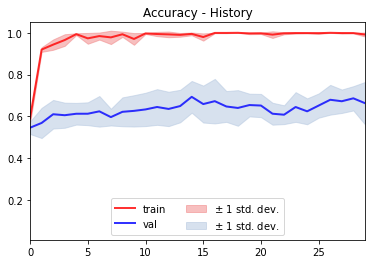

In [ ]:
model_noise_70.plot_accuracy()

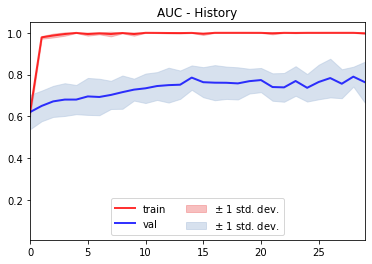

In [ ]:
model_noise_70.plot_loss()

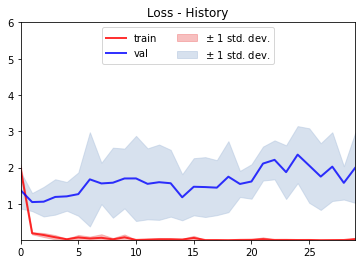

In [ ]:
model_noise_70.plot_auc()

# noise 0.9

In [ ]:
result_data, result_label = prepare_data(noisy_part = 0.9)

save_dir = '/content/drive/MyDrive/lyme_dataset/weights/ver_2/model_6/'

model_noise_90 = Complex_Model(result_data=result_data, result_label=result_label, save_dir=save_dir, epoch_num = EPOCHS)

dataset size:  1302


In [ ]:
 model_noise_90.run()

(224, 224, 3)
Epoch 1/30

Epoch 00001: val_auc improved from -inf to 0.73978, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_6/
33/33 - 27s - loss: 1.1064 - auc: 0.7447 - acc: 0.6849 - val_loss: 0.8074 - val_auc: 0.7398 - val_acc: 0.6743 - 27s/epoch - 818ms/step
Epoch 2/30

Epoch 00002: val_auc did not improve from 0.73978
33/33 - 13s - loss: 0.2555 - auc: 0.9661 - acc: 0.9222 - val_loss: 1.7618 - val_auc: 0.7194 - val_acc: 0.5632 - 13s/epoch - 384ms/step
Epoch 3/30

Epoch 00003: val_auc improved from 0.73978 to 0.78693, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_6/
33/33 - 13s - loss: 0.0917 - auc: 0.9938 - acc: 0.9645 - val_loss: 1.5916 - val_auc: 0.7869 - val_acc: 0.5939 - 13s/epoch - 397ms/step
Epoch 4/30

Epoch 00004: val_auc improved from 0.78693 to 0.81947, saving model to /content/drive/MyDrive/lyme_dataset/weights/ver_2/model_6/
33/33 - 13s - loss: 0.0573 - auc: 0.9980 - acc: 0.9789 - val_loss: 1.2618 - val_auc: 0.8195 - va

In [ ]:
model_noise_90.show_results()

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8884708881378174 - Accuracy: 0.8352490663528442 - AUC: 0.928449809551239%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5227726697921753 - Accuracy: 0.9195402264595032 - AUC: 0.9618613719940186%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.555536150932312 - Accuracy: 0.9115384817123413 - AUC: 0.9510058164596558%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.43657442927360535 - Accuracy: 0.9307692050933838 - AUC: 0.9731360077857971%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6018581390380859 - Accuracy: 0.8769230842590332 - AUC: 0.958579957485199%
------------------------------------------------------------------------
Averag

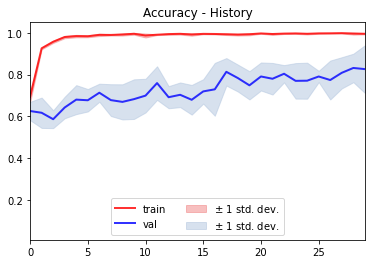

In [ ]:
model_noise_90.plot_accuracy()

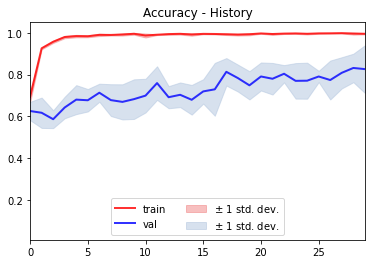

In [ ]:
model_noise_90.plot_accuracy()

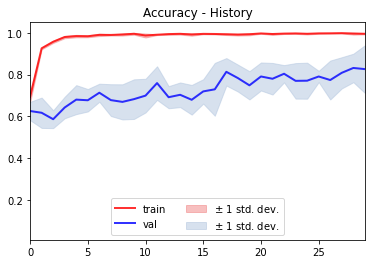

In [ ]:
model_noise_90.plot_accuracy()

## summary plots

In [ ]:
metrics_list_noise_0 = model_noise_0.folds_mean_max_auc()
metrics_list_noise_10 = model_noise_10.folds_mean_max_auc()
metrics_list_noise_30 = model_noise_30.folds_mean_max_auc()
metrics_list_noise_50 = model_noise_50.folds_mean_max_auc()
metrics_list_noise_70 = model_noise_70.folds_mean_max_auc()
metrics_list_noise_90 = model_noise_90.folds_mean_max_auc()

acc_mean_list = (metrics_list_noise_0[0], metrics_list_noise_10[0], metrics_list_noise_30[0], 
                 metrics_list_noise_50[0], metrics_list_noise_70[0], metrics_list_noise_90[0])

acc_std_list = (metrics_list_noise_0[1], metrics_list_noise_10[1], metrics_list_noise_30[1], 
                 metrics_list_noise_50[1], metrics_list_noise_70[1], metrics_list_noise_90[1])

auc_mean_list = (metrics_list_noise_0[2], metrics_list_noise_10[2], metrics_list_noise_30[2], 
                 metrics_list_noise_50[2], metrics_list_noise_70[2], metrics_list_noise_90[2])

auc_std_list = (metrics_list_noise_0[3], metrics_list_noise_10[3], metrics_list_noise_30[3], 
                 metrics_list_noise_50[3], metrics_list_noise_70[3], metrics_list_noise_90[3])

noise_list = [0, 10, 30, 50, 70, 90]




In [ ]:
def plot_noise_vs(x, y, x_label, y_label, plot_title):
  plt.plot(x, y)
  plt.xticks(x)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(plot_title)
  

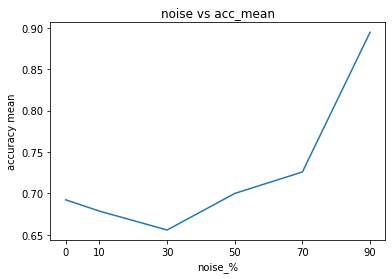

In [ ]:
plot_noise_vs(noise_list, acc_mean_list, 'noise_%', 'accuracy mean', 'noise vs acc_mean')

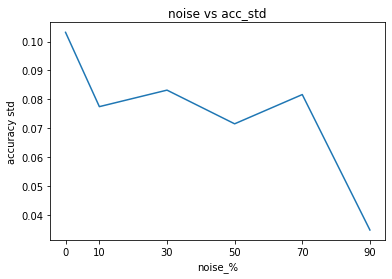

In [ ]:
plot_noise_vs(noise_list, acc_std_list, 'noise_%', 'accuracy std', 'noise vs acc_std')

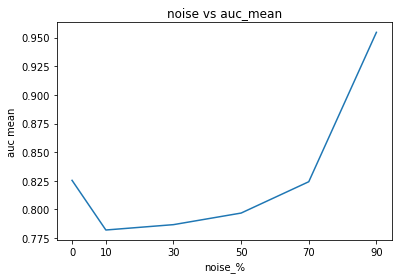

In [ ]:
plot_noise_vs(noise_list, auc_mean_list, 'noise_%', 'auc mean', 'noise vs auc_mean')

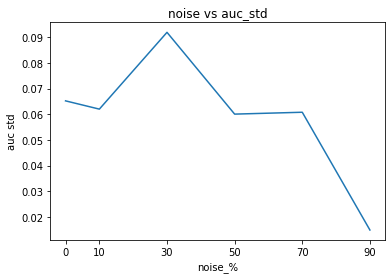

In [ ]:
plot_noise_vs(noise_list, auc_std_list, 'noise_%', 'auc std', 'noise vs auc_std')